In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shortest_path import ShortestPath

/home/rdave/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
address_list1 = [
    "1000 Olin Way, Needham, MA",
    "958 Highland Ave, Needham, MA",
    "Medford, MA",
]

address_list2 = [
    '320 D St, Boston, MA',
    '11 Dorchester St, Boston, MA'
]

address_list = address_list2 # Switch to address_list1 or any others for new set of nodes

# Create ShortestPath object and initialize graph
alg = ShortestPath(address_list, 1000)
start = address_list[0]
end = address_list[1]

start_id = alg.nearest_node(start)
end_id = alg.nearest_node(end)

Converting addresses...
Adding '320 D St, Boston, MA' to dictionary.
Adding '11 Dorchester St, Boston, MA' to dictionary.
Creating graph...


/home/rdave/.local/lib/python3.10/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8-0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, "cluster"] = f"{cluster_label}-{suffix}"


MultiDiGraph with 353 nodes and 766 edges
Graph created & setup complete.


In [16]:
# Find max flow from start to end and add flow to graph attributes
max_flow, flowDict = alg.max_flow_path(start, end)
actual_flow = ox.graph_to_gdfs(alg.graph, nodes=False)['actual_flow'].fillna(0)
nx.set_edge_attributes(alg.graph, actual_flow, 'actual_flow')
print("Max flow possible: ", max_flow)

# Find min cut edges (bottleneck)
cut_value, partition, cutset = alg.min_cut(start, end)
print("Min cut (should match max flow): ", cut_value)
print("Edges making min cut: ", cutset)

Max flow possible:  6200.0
Min cut (should match max flow):  6200.0
Edges making min cut:  {(121, 32), (103, 32), (30, 32), (110, 32)}


121 114
121 105


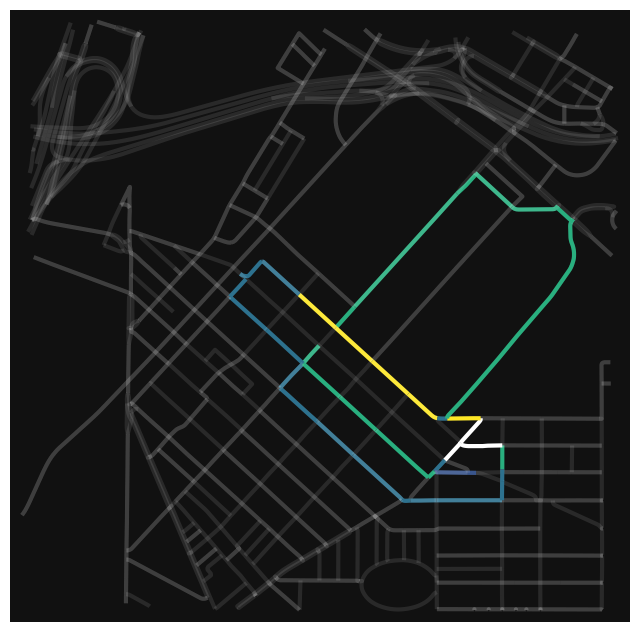

In [18]:
import pandas as pd
import matplotlib

# Map actual flow to color gradient
colors = ox.plot.get_edge_colors_by_attr(alg.graph, attr="actual_flow", cmap="viridis")

edge_has_flow = []

# Create list of 0/1 representing if that edge has flow or not
for u, v, ind in alg.graph.edges:
    if u == 121:
        print(u, v)
    if (u, v) in cutset:
        edge_has_flow.append(2)
    elif alg.graph[u][v][ind]['actual_flow'] == 0.0:
        edge_has_flow.append(1)
    else:
        edge_has_flow.append(0)

# Edit color so that 0.0 flow maps to translucent white, not the purple from viridis's 0
# Min cut values currently map to (1, 1, 1, 1) and are very bright. Comment out this section
# And uncomment the next one to ignore mincut for the graph
for index, value in colors.items():
    if edge_has_flow[0] == 1:
        colors[index] = (1, 1, 1, 0.1)
    elif edge_has_flow[0] == 2:
        colors[index] = (1, 1, 1, 1)
    edge_has_flow.pop(0)

# Uncomment this section and comment the above one to ignore mincut
# for index, value in colors.items():
#     if edge_has_flow[0] == 1:
#         colors[index] = (1, 1, 1, 0.1)
#     edge_has_flow.pop(0)

# Plot max flow path with color gradient and save image
fig, ax = ox.plot_graph(alg.graph, node_size=0, edge_linewidth =3, edge_color=colors)
fig.colorbar(matplotlib.cm.ScalarMappable(cmap="viridis"), ax=ax)
fig.savefig("MaxFlow.png")

Max Flow Dijkstra (Time):  700.0


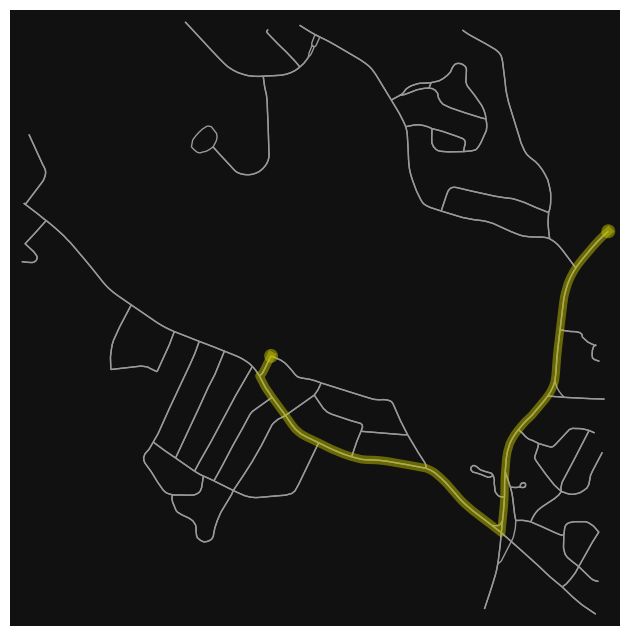

In [7]:
# OSMnx Dijkstra's by Travel Time
dijkstra_shortest_path_list_time = alg.d_shortest_path(address_list[0], address_list[1], weight="travel_time")

# Max flow for shortest path is the bottleneck capacity
max_flow_djkstra = 1900
for u, v, ind in alg.graph.edges:
    if alg.graph[u][v][ind]["actual_flow"] > 0.00:
        if alg.graph[u][v][ind]["actual_flow"] < max_flow_djkstra:
            max_flow_djkstra = alg.graph[u][v][ind]["actual_flow"]
print("Max Flow Dijkstra (Time): ", max_flow_djkstra)

fig, ax = ox.plot_graph_route(alg.graph, dijkstra_shortest_path_list_time, route_color="y", route_linewidth=6, node_size=0)

Max Flow Dijkstra (Distance):  700.0


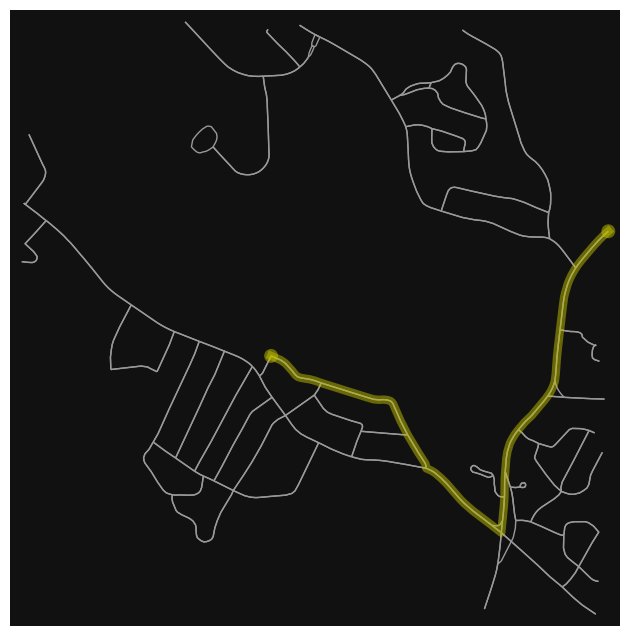

In [8]:
# OSMnx Dijkstra's by Distance
dijkstra_shortest_path_list_distance = alg.d_shortest_path(address_list[0], address_list[1], weight="length")

# Max flow for shortest path is the bottleneck capacity
max_flow_djkstra = 1900
for u, v, ind in alg.graph.edges:
    if alg.graph[u][v][ind]["actual_flow"] > 0.00:
        if alg.graph[u][v][ind]["actual_flow"] < max_flow_djkstra:
            max_flow_djkstra = alg.graph[u][v][ind]["actual_flow"]
print("Max Flow Dijkstra (Distance): ", max_flow_djkstra)

fig, ax = ox.plot_graph_route(alg.graph, dijkstra_shortest_path_list_distance, route_color="y", route_linewidth=6, node_size=0)

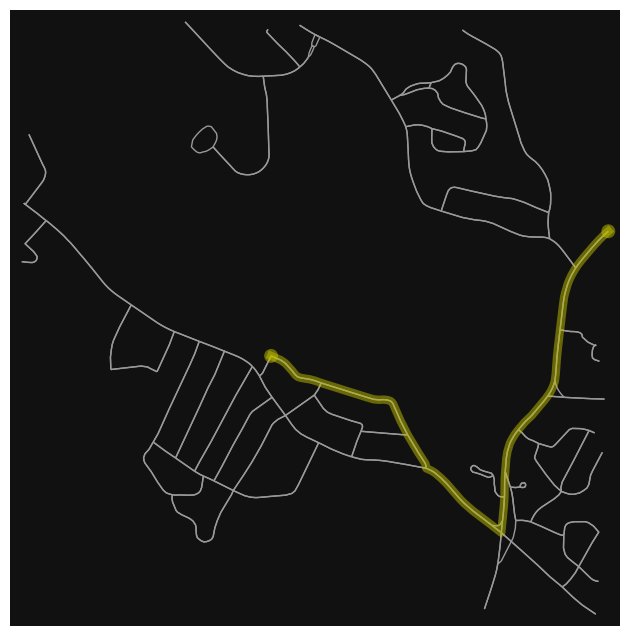

In [10]:
#* NX A* no heuristic = dijkstra's
astar_shortest_path_list = alg.astar_shortest_path(address_list[0], address_list[1], weight="travel_time")

fig, ax = ox.plot_graph_route(alg.graph, astar_shortest_path_list, route_color="y", route_linewidth=6, node_size=0)

In [2]:
# NX Dijkstra's
start_node = alg.nearest_node(address_list[0])
end_node = alg.nearest_node(address_list[1])
print(start_node)
print(end_node)
d_nx_shortest_path_list = nx.dijkstra_path(alg.graph, start_node[0], end_node[0])
print(d_nx_shortest_path_list)
fig, ax = ox.plot_graph_route(alg.graph, d_nx_shortest_path_list, route_color="y", route_linewidth=6, node_size=0)

NameError: name 'alg' is not defined